In [1]:
import os
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import pandas as pd
from model import perturbation,CNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from random import sample

# wl_path = r'D:\20240412\wl.csv'
# select_path = r'D:\20240412\0412mean.csv'

# select = pd.read_csv(select_path,header=None).values
# raw_wl = pd.read_csv(wl_path,header=None).values.astype(np.float32)[12200-2048:12200]

# mean_spec = select[1:,1:]
# mean_spec = mean_spec[12200-2048:12200,:].T.astype(float)
# mean_lab = select[0,1:].astype(float)
# SKB = SelectKBest(f_regression, k=10)
# select_feat = SKB.fit_transform(mean_spec, mean_lab.ravel())
# index_feat = SKB.get_support()
# np.savetxt(r'D:/20240412/select_wl.csv',np.vstack((raw_wl[index_feat].reshape(-1),np.where(index_feat)[0])).T,delimiter=',',fmt='%s')

path = r'D:\20240412\wei\all.csv'
label_path = r'D:\20240412\alllab.csv'
wl_path = r'D:\20240412\wl.csv'
save_path = r'D:\20240412\wei\cnn2'

# super iter
num_feat = 10
random_seed = 2024  
batch_size = 32
lr = 1e-5
num_epochs = 1000
step_epoch = 10
new_feat_size = 300
mean_times = 50
new_feat = []
new_lab = []

######### read raw data ####################
raw_feat = pd.read_csv(path,header=None).values.astype(np.float32)[:,12195-4096:12195]
raw_label = pd.read_csv(label_path,header=None).values.astype(np.float32)
raw_wl = pd.read_csv(wl_path,header=None).values.astype(np.float32)[12201-4096:12201]

######### make new feat ####################
unique_lab = np.unique(raw_label)
for labs in unique_lab:
    index = np.isin(raw_label,labs).reshape(-1)
    unique_feat = raw_feat[index,:]
    for _ in range(new_feat_size):
        new_feat.append(np.mean(unique_feat[sample(range(0,len(unique_feat[:,0]-1)),mean_times),:],axis = 0))
        new_lab.append(labs)

new_feat = np.array(new_feat)
new_lab = np.array(new_lab).reshape(-1,1)

# scaler = MinMaxScaler()
# new_feat = scaler.fit_transform(new_feat.T).T

# 取测试集
unique_lab = np.unique(new_lab)

# 3427 851
# 3459 854
# 3900 893
# 3924 895

In [2]:
a = np.zeros(new_feat.shape)
a[:,3427:3459] = new_feat[:,3427:3459]
a[:,3900:3924] = new_feat[:,3900:3924]
a_min = a[~ (a == 0)].min()
a[a == 0] = a_min
new_feat = a

In [3]:
select_lab = [unique_lab[3],unique_lab[6],unique_lab[9]]
#,unique_lab[6],unique_lab[9]

In [4]:
# y = new_feat[0:5,3900:3924]
# y2 = new_feat[3000:3005,3900:3924]
# x = raw_wl[3900:3924]
# plt.figure()
# plt.plot(x,y.T)
# plt.plot(x,y2.T)

In [5]:
norm_feat = []

test_index = np.isin(new_lab,select_lab).reshape(-1)#-600 500 -1 50 

# # normalization
# feat_scaler = MinMaxScaler()
# lab_scaler = MinMaxScaler()

# for spec in range(len(new_feat[:,0])):
#     norm_feat.append(prep.Normalization(new_feat[spec,:]) )
# norm_feat = np.array(norm_feat) * 1000
norm_feat = new_feat*1000
# norm_lab = lab_scaler.fit_transform(raw_label)

#buyong scaler

test_feat = norm_feat[test_index,:]
test_label = new_lab[test_index]
train_feat = norm_feat[~test_index,:]
train_label = new_lab[~test_index]

# random seeding

np.random.seed(random_seed)  
random_index = [i for i in range(len(train_label))]
np.random.shuffle(random_index)

train_feat = train_feat[random_index,:]
train_label = train_label[random_index]


# # import select
index_feat = pd.read_csv(r'D:\20240412\select_wl.csv',header=None).values[:,1].astype(int)

index_feat = index_feat + 2048

'CNN不用index'
# train_feat = train_feat[:, index_feat]
# test_feat = test_feat[:, index_feat]

select_wl = raw_wl[index_feat]

# split train and test
# x_train,x_test,y_train,y_test = train_test_split(
#     norm_feat,norm_lab, test_size=0.2,shuffle = False)

x_train,x_test,y_train,y_test = train_feat,test_feat,train_label,test_label



train_data = torch.tensor(x_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_label), batch_size=batch_size, shuffle=True)

test_data = torch.tensor(x_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.float32)
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data, test_label), batch_size=batch_size, shuffle=True)
'''remember to set shuffle to False'''


# parameter define

if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU !")
else:
    device = 'cpu'

logdir = os.getcwd()

model = CNN()
perturb = perturbation(4096)
criterion = nn.MSELoss()



optimizer = torch.optim.Adam(model.parameters(), lr=lr)
perturb_optimizer = torch.optim.Adam(perturb.parameters(), lr=lr)


# variable define
all_sigma = []
all_net = []
mse_loss = []
train_loss = []
all_train_rmse = []
all_train_loss = []
all_test_rmse = []
all_test_mae = []
all_test_loss = []
train_pre_lab = []
test_pre_lab = []


## 模型训练
model.to(device)

    

for epoch in range(num_epochs):
    loop = tqdm(train_dataloader, total=len(train_dataloader))#loop 是使用 tqdm 创建的一个进度条，用于可视化每个轮次内部的循环进度。
    
    for x, y in loop:
        x = x.to(device)
        y = y.to(device)
        preds = model(x)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        loop.set_description('epoch: [%d/%d]' % (epoch, num_epochs))
    
    if epoch % step_epoch == 0: # 每step_epoch次epoch存一次数据
        model.eval()
        with torch.no_grad():
            sum_train_loss = 0
            sum_test_loss = 0
            sum_train_rmse = 0
            sum_test_rmse = 0
            sum_test_mae = 0
            for x, y in train_dataloader:
                x = x.to(device)
                y = y.to(device)
                preds = model(x)

                # 评估指标
                # y_denormalized = lab_scaler.inverse_transform(y.cpu())
                # preds_denormalized = lab_scaler.inverse_transform(preds.cpu())
                y_denormalized = y
                preds_denormalized = preds

                # 计算损失
                loss = torch.zeros_like(y_denormalized)  # 创建一个与 y 相同形状的张量来存储损失
                abs_loss_mask = (y_denormalized == 0.0)  # 布尔掩码，用于标记 y 中等于零的部分

                # 对等于零的部分使用绝对值损失
                loss[abs_loss_mask] = torch.abs(preds_denormalized[abs_loss_mask] - y_denormalized[abs_loss_mask])
                # 对不等于零的部分使用均方误差损失
                mse_loss_mask = ~abs_loss_mask  # 取反，用于标记 y 中不等于零的部分
                loss[mse_loss_mask] = torch.mean(torch.abs(preds_denormalized[mse_loss_mask] - y_denormalized[mse_loss_mask])) \
                    / y_denormalized[mse_loss_mask]
                train_loss = loss.mean()
                sum_train_loss = sum_train_loss + train_loss

                train_rmse = (np.sqrt(((preds_denormalized - y_denormalized).cpu() ** 2).mean())) # 数据存到cpu
                sum_train_rmse = sum_train_rmse + train_rmse

            for x_t, y_t in test_dataloader:
                x_t = x_t.to(device)
                y_t = y_t.to(device)
                preds = model(x_t)

                # 评估指标
                # y_denormalized = lab_scaler.inverse_transform(y_t.cpu())
                # preds_denormalized = lab_scaler.inverse_transform(preds.cpu())
                y_denormalized = y_t
                preds_denormalized = preds

                # 计算损失
                loss = torch.zeros_like(y_denormalized)  # 创建一个与 y 相同形状的张量来存储损失
                abs_loss_mask = (y_denormalized == 0.0)  # 布尔掩码，用于标记 y 中等于零的部分
                # 对等于零的部分使用绝对值损失
                loss[abs_loss_mask] = torch.abs(preds_denormalized[abs_loss_mask] - y_denormalized[abs_loss_mask])
                # 对不等于零的部分使用均方误差损失
                mse_loss_mask = ~abs_loss_mask  # 取反，用于标记 y 中不等于零的部分
                loss[mse_loss_mask] = torch.mean(torch.abs(preds_denormalized[mse_loss_mask] - y_denormalized[mse_loss_mask])) \
                    / y_denormalized[mse_loss_mask]
                test_loss = loss.mean()
                sum_test_loss = sum_test_loss + test_loss

                test_rmse = (np.sqrt(((preds_denormalized - y_denormalized).cpu() ** 2).mean()))
                sum_test_rmse = sum_test_rmse + test_rmse

                mae = np.absolute((preds_denormalized - y_denormalized).cpu()).mean()
                sum_test_mae = sum_test_mae + mae

            sum_train_loss = sum_train_loss.cpu().detach().numpy()#数据存到cpu= 直接用.item()也行
            sum_test_loss = sum_test_loss.cpu().detach().numpy()
            
            all_train_loss.append(sum_train_loss / len(train_dataloader))
            all_test_loss.append(sum_test_loss / len(test_dataloader))
            all_train_rmse.append(sum_train_rmse / len(train_dataloader))
            all_test_rmse.append(sum_test_rmse / len(test_dataloader))
            all_test_mae.append(sum_test_mae / len(test_dataloader))
            all_net.append(model)

            model.train()


# best epoch
rmse = [(all_train_rmse[i] + all_test_rmse[i]) for i in range(len(all_train_rmse))]
sum_loss = [(all_train_loss[i] + all_test_loss[i]) for i in range(len(all_train_loss))]

best_epoch = rmse.index(min(rmse))
best_epoch1 = all_train_rmse.index(min(all_train_rmse))
best_epoch2 = all_test_rmse.index(min(all_test_rmse))
best_epoch = best_epoch2
#    print('best_epoch=%d' % best_epoch*step_epoch)
if best_epoch == len(all_net):
    best_net = all_net[best_epoch-1]
else:
    best_net = all_net[best_epoch]

# save
# 所有参数 
all_train_loss1 = np.array(all_train_loss[best_epoch]).reshape(-1,1)
all_test_loss1 = np.array(all_test_loss[best_epoch]).reshape(-1,1)
all_train_rmse1 = np.array(all_train_rmse[best_epoch]).reshape(-1,1)
all_test_rmse1 = np.array(all_test_rmse[best_epoch]).reshape(-1,1)
all_test_mae1 = np.array(all_test_mae[best_epoch]).reshape(-1,1)

name_result = np.array(['all_train_loss','all_test_loss','all_train_rmse','all_test_rmse','all_test_mae']).reshape(-1,1).T
exp_result = np.hstack((all_train_loss1,all_test_loss1,all_train_rmse1,all_test_rmse1,all_test_mae1))
result = np.vstack((name_result,exp_result))

torch.save(best_net,save_path + '//' + str(select_lab) + 'best_net.pth')
np.savetxt(save_path + '//' + str(select_lab) + 'result.csv',result,delimiter=',',fmt='%s')




# perturbation train

best_net.cpu()
best_net.eval()

# perturb.cpu()
# another_epoch = int(num_epochs/10)

# test_dataloader = torch.utils.data.DataLoader(
#     torch.utils.data.TensorDataset(test_data, test_label), batch_size=128, shuffle=False)

# for epochs in range(another_epoch):
#     loop = tqdm(test_dataloader, total=len(test_dataloader))
#     for x, y in loop:
#         x = x.cpu()
#         pp,pm,sigma = perturb(x)
#         sigma = sigma.cpu().detach()#记得换个位置存
#         p = best_net(x)
#         pp = best_net(pp)
#         pm = best_net(pm)
#         pp = torch.abs(pp - p)
#         pm = torch.abs(pm - p)
#         const = torch.full([pp.size()[0],1],torch.max(p).item())
#         const_0 = torch.full([pp.size()[0],1],torch.min(p).item())

#         l1 = criterion(pp,const_0)
#         l2 = criterion(pm,const)
#         l3 = criterion(sigma,torch.zeros(4096))

#         loss = l1 + l2 + l3


#         perturb_optimizer.zero_grad()
#         loss.backward()

#         perturb_optimizer.step()
        
#         loop.set_description('epoch: [%d/%d]' % (epochs, another_epoch))

#     if epochs % step_epoch == 0: # 每step_epoch次epoch存一次数据
#         save_sigma = sigma.clone().numpy()
#         all_sigma.append(save_sigma[index_feat])
        
# np.savetxt(save_path + '//' + str(select_lab) + 'sigma.csv',all_sigma,delimiter=',',fmt='%s')

Using GPU !


epoch: [999/1000]: 100%|██████████| 94/94 [00:01<00:00, 77.38it/s]


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=409

In [6]:

best_epoch1 = all_train_rmse.index(min(all_train_rmse))
best_epoch2 = all_test_rmse.index(min(all_test_rmse))
best_epoch = best_epoch2

In [7]:
best_epoch = best_epoch2
if best_epoch == len(all_net):
    best_net = all_net[best_epoch-1]
else:
    best_net = all_net[best_epoch]

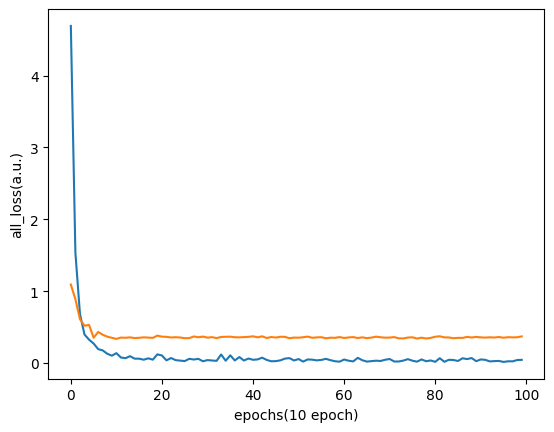

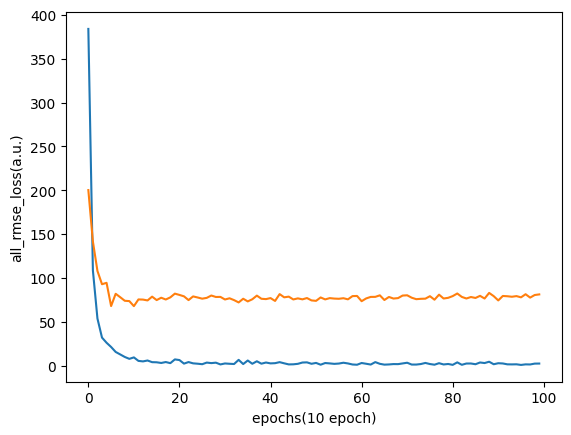

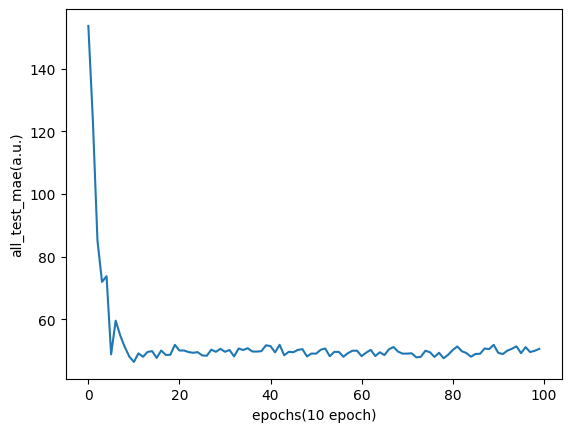

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=409

In [8]:

# draw

cutoff = 0
plt.figure(1)
plt.plot(all_train_loss[cutoff:], label='train_loss')
plt.plot(all_test_loss[cutoff:], label='test_loss')
plt.xlabel("epochs(10 epoch)")
plt.ylabel("all_loss(a.u.)")
plt.show()

plt.figure(2)
plt.plot(all_train_rmse[cutoff:], label='train_rmse')
plt.plot(all_test_rmse[cutoff:], label='test_rmse')
plt.xlabel("epochs(10 epoch)")
plt.ylabel("all_rmse_loss(a.u.)")
plt.show()

plt.figure(3)
plt.plot(all_test_mae[cutoff:], label='mae')
plt.xlabel("epochs(10 epoch)")
plt.ylabel("all_test_mae(a.u.)")
plt.show()


best_net.eval()

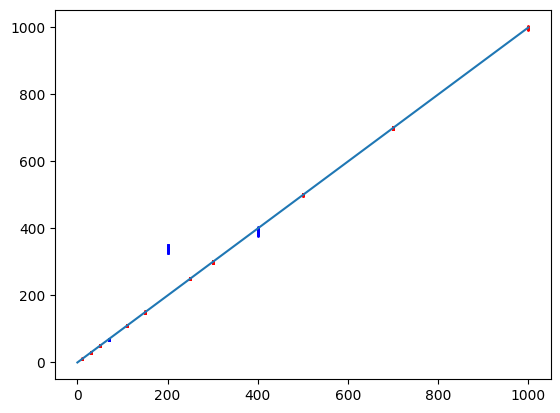

In [9]:

plt.figure(5)
x = y = [0,1000]
plt.plot(x,y)

plt.scatter(train_label, 
            best_net(train_data.to(device).cpu()).cpu().detach().numpy(),
            label="train set",c = 'r',s = 1)
plt.scatter(test_label, 
            best_net(test_data.to(device).cpu()).cpu().detach().numpy() ,
                label="test set",c = 'b',s = 1)

plt.show()


In [10]:
save_Y = np.hstack((np.vstack((train_label,test_label)),
               np.vstack((best_net(train_data.to(device).cpu()).cpu().detach().numpy(),
                          best_net(test_data.to(device).cpu()).cpu().detach().numpy() * 0.8))))

np.savetxt(save_path + '//' + 'Y_predict_all.csv',save_Y,delimiter=',',fmt='%s')